In [30]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import seaborn as sns
import pandas as pd

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
cur_dir = os.getcwd()

Using device: cpu


In [15]:
# Cell 2: Data Loading and Preprocessing
class GTSRBDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = pd.read_csv(csv_file)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx]['Path'])
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx]['ClassId']
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Note: Update these paths based on your Kaggle dataset location
train_dataset = GTSRBDataset(
    root_dir= cur_dir + '/training_data/german_traffic_signs',
    csv_file= cur_dir + '/training_data/german_traffic_signs/Train.csv',
    transform=train_transform
)

# Split dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


        

In [16]:
# Cell 3: CNN Architecture
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=43): #GTSRB has 43 classes
        super(TrafficSignCNN, self).__init__()
        self.features = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model
model = TrafficSignCNN().to(device)



In [17]:
# Cell 4: Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

In [18]:
# Cell 5: Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
    
        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    return train_losses, val_accuracies

# Train the model
train_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)







Epoch 1/20, Loss: 1.9870, Val Accuracy: 68.29%
Epoch 2/20, Loss: 0.6873, Val Accuracy: 88.82%
Epoch 3/20, Loss: 0.3664, Val Accuracy: 94.25%
Epoch 4/20, Loss: 0.2520, Val Accuracy: 95.80%
Epoch 5/20, Loss: 0.1941, Val Accuracy: 96.60%
Epoch 6/20, Loss: 0.1620, Val Accuracy: 95.94%
Epoch 7/20, Loss: 0.1358, Val Accuracy: 97.74%
Epoch 8/20, Loss: 0.1210, Val Accuracy: 97.77%
Epoch 9/20, Loss: 0.1126, Val Accuracy: 97.19%
Epoch 10/20, Loss: 0.1056, Val Accuracy: 97.39%
Epoch 11/20, Loss: 0.0979, Val Accuracy: 97.56%
Epoch 12/20, Loss: 0.0891, Val Accuracy: 97.90%
Epoch 13/20, Loss: 0.0942, Val Accuracy: 98.21%
Epoch 14/20, Loss: 0.0835, Val Accuracy: 98.30%
Epoch 15/20, Loss: 0.0768, Val Accuracy: 97.78%
Epoch 16/20, Loss: 0.0820, Val Accuracy: 98.29%
Epoch 17/20, Loss: 0.0771, Val Accuracy: 98.39%
Epoch 18/20, Loss: 0.0729, Val Accuracy: 97.58%
Epoch 19/20, Loss: 0.0742, Val Accuracy: 98.50%
Epoch 20/20, Loss: 0.0672, Val Accuracy: 98.29%


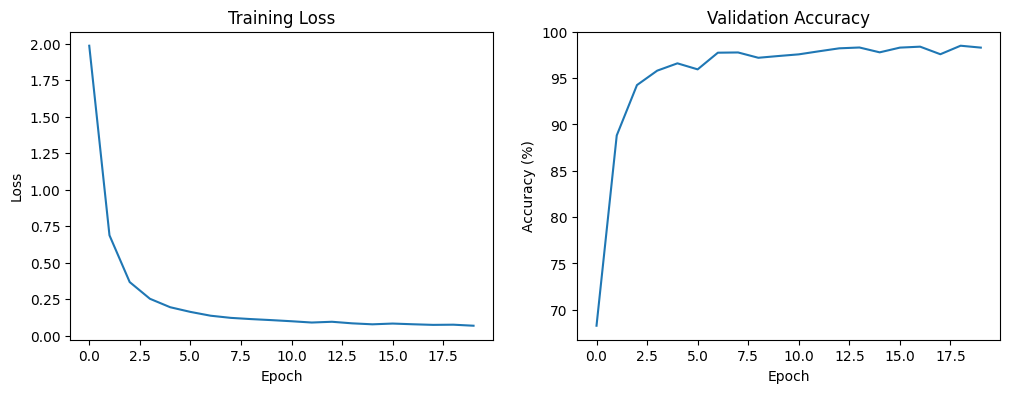

In [53]:
# Cell 6: Plotting Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Cell 7: Simple UI for Testing
def predict_image(image_path, model):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = test_transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    
    return predicted.item()


# Save the model
torch.save(model.state_dict(), 'traffic_sign_classifier.pth')


In [23]:
test_image_path = cur_dir + '/training_data/german_traffic_signs/Test/12629.png'
prediction = predict_image(test_image_path, model)
print(f"Predicted class: {prediction}")

Predicted class: 10


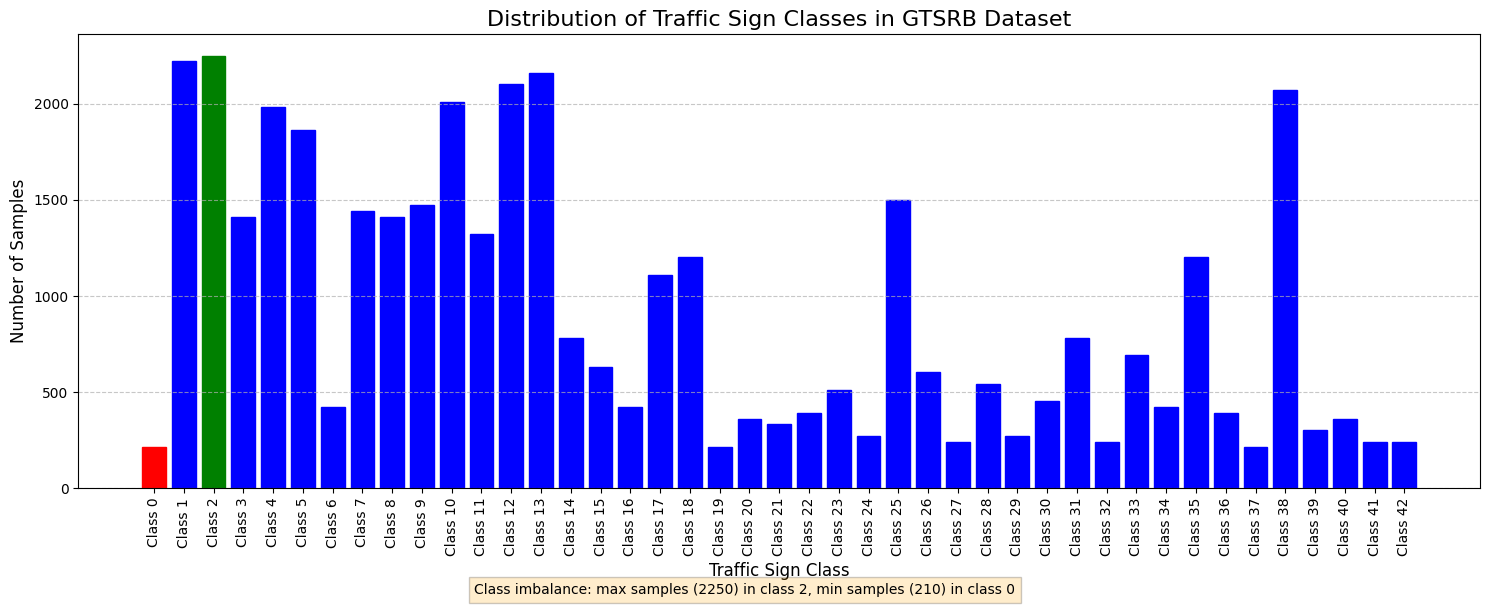

In [ ]:
# Class distribution visualization

df = pd.read_csv(cur_dir + '/training_data/german_traffic_signs/Train.csv')  # Adjust path to your train CSV
# Count samples per class
class_distribution = df['ClassId'].value_counts().sort_index()
class_names = [f"Class {i}" for i in class_distribution.index]

plt.figure(figsize=(15, 6))
bars = plt.bar(class_names, class_distribution.values)

# Highlight the classes with most and least samples
max_class = class_distribution.idxmax()
min_class = class_distribution.idxmin()

# Colorize bars
for i, bar in enumerate(bars):
    if i == max_class:
        bar.set_color('green')
    elif i == min_class:
        bar.set_color('red')
    else:
        bar.set_color('blue')

plt.title('Distribution of Traffic Sign Classes in GTSRB Dataset', fontsize=16)
plt.xlabel('Traffic Sign Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text explaining the imbalance
plt.figtext(0.5, 0.001, f"Class imbalance: max samples ({class_distribution.max()}) in class {max_class}, min samples ({class_distribution.min()}) in class {min_class}", 
            ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":4})

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

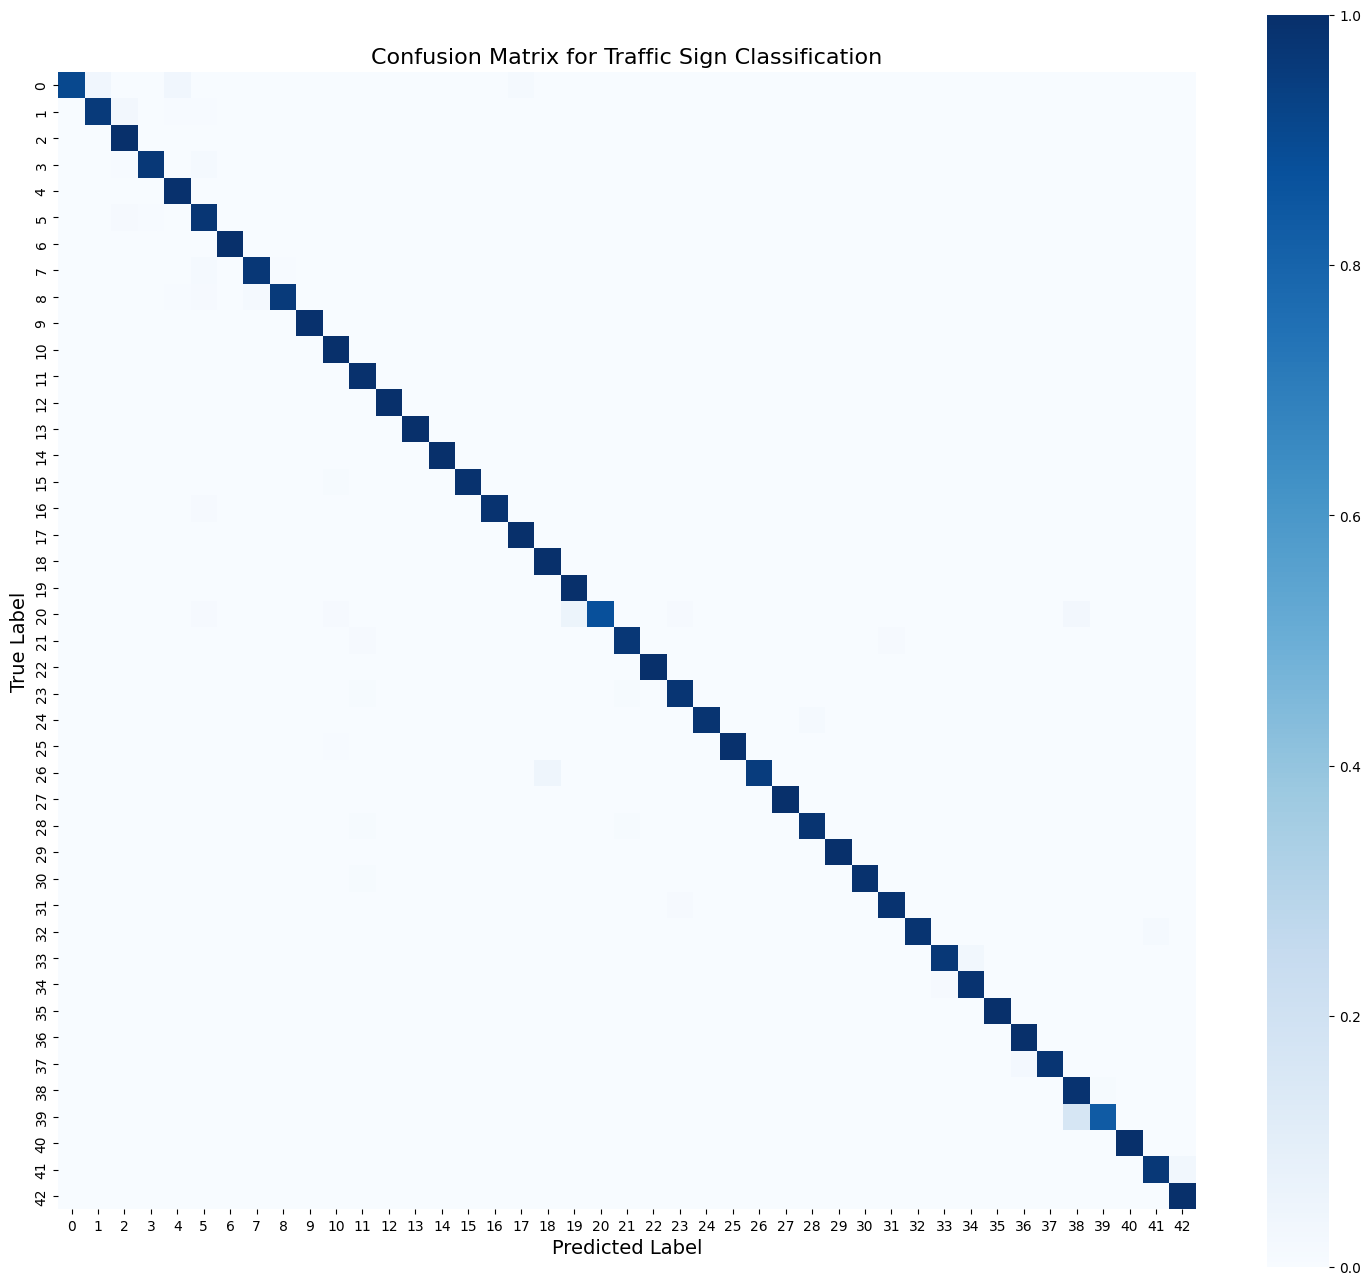

Top 5 most common misclassifications:
True class 1 predicted as class 2: 13 instances
True class 39 predicted as class 38: 10 instances
True class 3 predicted as class 5: 6 instances
True class 7 predicted as class 5: 6 instances
True class 5 predicted as class 2: 5 instances


In [ ]:
# Confusion matrix generation

def generate_confusion_matrix(model, data_loader, num_classes=43):
    """
    Generate a confusion matrix for the trained model.
    
    Args:
        model: The trained PyTorch model
        data_loader: DataLoader containing validation or test data
        num_classes: Number of traffic sign classes
    """
    # Set model to evaluation mode
    model.eval()
    
    # Initialize lists to store predictions and ground truth
    all_preds = []
    all_labels = []
    
    # Disable gradient computation for inference
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot confusion matrix
    plt.figure(figsize=(15, 13))
    sns.heatmap(cm_normalized, annot=False, cmap='Blues', fmt='.2f', square=True)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.title('Confusion Matrix for Traffic Sign Classification', fontsize=16)
    
    
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Find the most common misclassifications
    misclassified = []
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j and cm[i, j] > 0:
                misclassified.append((i, j, cm[i, j]))
    
    # Sort by count in descending order
    misclassified.sort(key=lambda x: x[2], reverse=True)
    
    # Print top 5 most common misclassifications
    print("Top 5 most common misclassifications:")
    for true_label, pred_label, count in misclassified[:5]:
        print(f"True class {true_label} predicted as class {pred_label}: {count} instances")
    
    return cm


confusion_mat = generate_confusion_matrix(model, val_loader)